In [1]:
import os

import numpy as np
import pandas as pd
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map

In [2]:
data_dir = "/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/"
out_dir = os.path.join(data_dir, "derivatives", "nilearn_glm")

emotion_names = [
    "JoyfulActivation",
    "Nostalgia",
    "Peacefulness",
    "Power",
    "Sadness",
    "Tenderness",
    "Tension",
    "Transcendence",
    "Wonder",
]

subject_list = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]

n_subjects = len(subject_list)
n_emotions = len(emotion_names)

In [3]:
import nibabel as nib
from nilearn.image import math_img, resample_img
from templateflow import api as tflow

# T1w image
t1w_img = tflow.get("MNI152NLin2009cAsym", desc="brain", resolution=1, suffix="T1w", extension="nii.gz")
t1w_gm_img = tflow.get("MNI152NLin2009cAsym", label="GM", suffix="probseg", resolution=2, extension="nii.gz")

# Gray Matter Mask
gm_prob_mask = nib.load(t1w_gm_img)
gm_mask = math_img("img > 0.15", img=gm_prob_mask)
example_map = nib.load(os.path.join(out_dir, "sub-01_task-02a_stat-z_con-JoyfulActivation.nii.gz"))
gm_mask_resampled = resample_img(
    gm_mask, target_affine=example_map.affine, target_shape=example_map.shape[0:3], interpolation="nearest", force_resample=True, copy_header=False
)


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_49643/2518605730.py:13: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  gm_mask_resampled = resample_img(


In [4]:
# === Step 1: Provide list of subject-level contrast maps ===
# # List all zmap nii.gz files for all emotions
zmap_files = []
for emotion in emotion_names:
    for subject in subject_list:
        zmap_files.append(os.path.join(out_dir, f"sub-{subject}_task-02a_stat-z_con-{emotion}.nii.gz"))

# Sort the zmap files
zmap_files.sort()

In [5]:
zmap_files

['/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-JoyfulActivation.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Nostalgia.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Peacefulness.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Power.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Sadness.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Tenderness.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Tension.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Transcendence.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Wonder.nii.gz',
 '/Volumes/T7/B

In [6]:
len(zmap_files)

180

In [7]:
# === Step 2: Create design matrix ===

# Build long-format design info
rows = []
for subj in subject_list:
    for cond in emotion_names:
        rows.append({"subject_label": subj, "emotion": cond})

design_info = pd.DataFrame(rows)

# One-hot encode
dm = pd.get_dummies(design_info, columns=["emotion"], drop_first=False)
# Remove subject_label (not needed in X matrix)
dm_X = dm.drop(columns=["subject_label"])

In [8]:
dm_X

,emotion_JoyfulActivation,emotion_Nostalgia,emotion_Peacefulness,emotion_Power,emotion_Sadness,emotion_Tenderness,emotion_Tension,emotion_Transcendence,emotion_Wonder
0,True,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...
175,False,False,False,False,True,False,False,False,False
176,False,False,False,False,False,True,False,False,False
177,False,False,False,False,False,False,True,False,False
178,False,False,False,False,False,False,False,True,False


In [10]:
# === Step 3: Fit the second-level model ===
second_level_model = SecondLevelModel(smoothing_fwhm=4, mask_img=gm_mask_resampled)
second_level_model = second_level_model.fit(zmap_files, design_matrix=dm_X)


In [11]:
# === Step 4: Perform F-test across all emotion regressors ===

contrast_matrix = np.eye(len(emotion_names))  # F-test: one row per regressor

contrast_matrix

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [12]:
z_map = second_level_model.compute_contrast(second_level_contrast=contrast_matrix, second_level_stat_type="F", output_type="z_score")


In [13]:
f_map = second_level_model.compute_contrast(second_level_contrast=contrast_matrix, second_level_stat_type="F", output_type="stat")

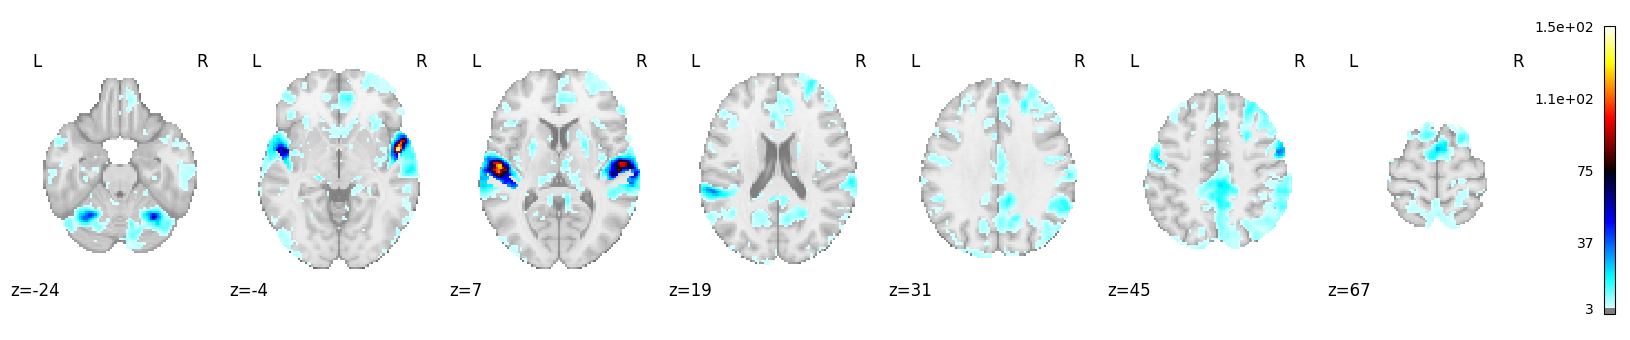

In [14]:
plot_stat_map(f_map, display_mode="z", cut_coords=7, colorbar=True, threshold=3)

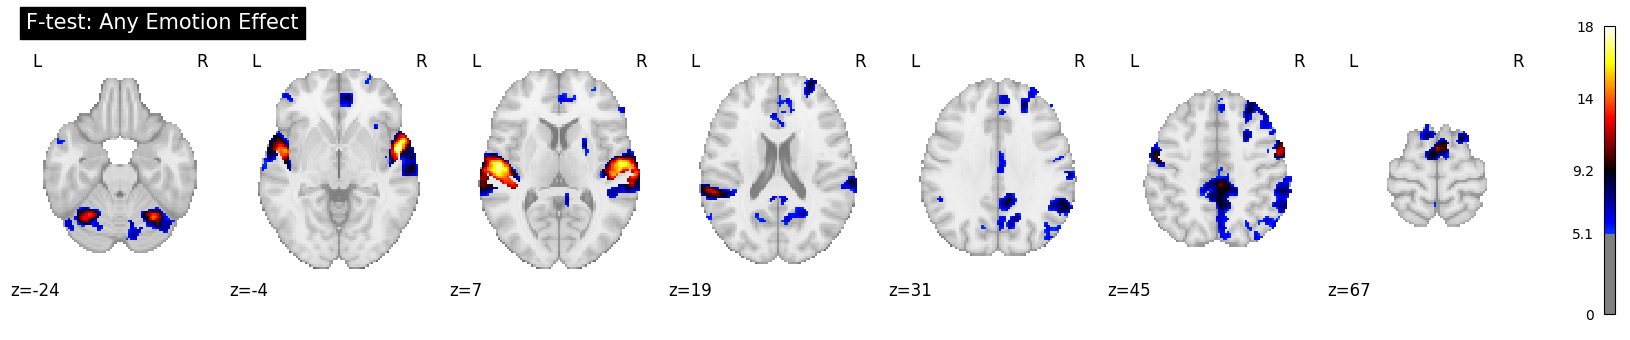

In [24]:
# === Step 5: Threshold the map and plot ===

thresholded_map, threshold = threshold_stats_img(z_map, alpha=0.05, height_control="bonferroni", cluster_threshold=25)

plot_stat_map(thresholded_map, threshold=threshold, title="F-test: Any Emotion Effect", display_mode="z", cut_coords=7, colorbar=True)

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



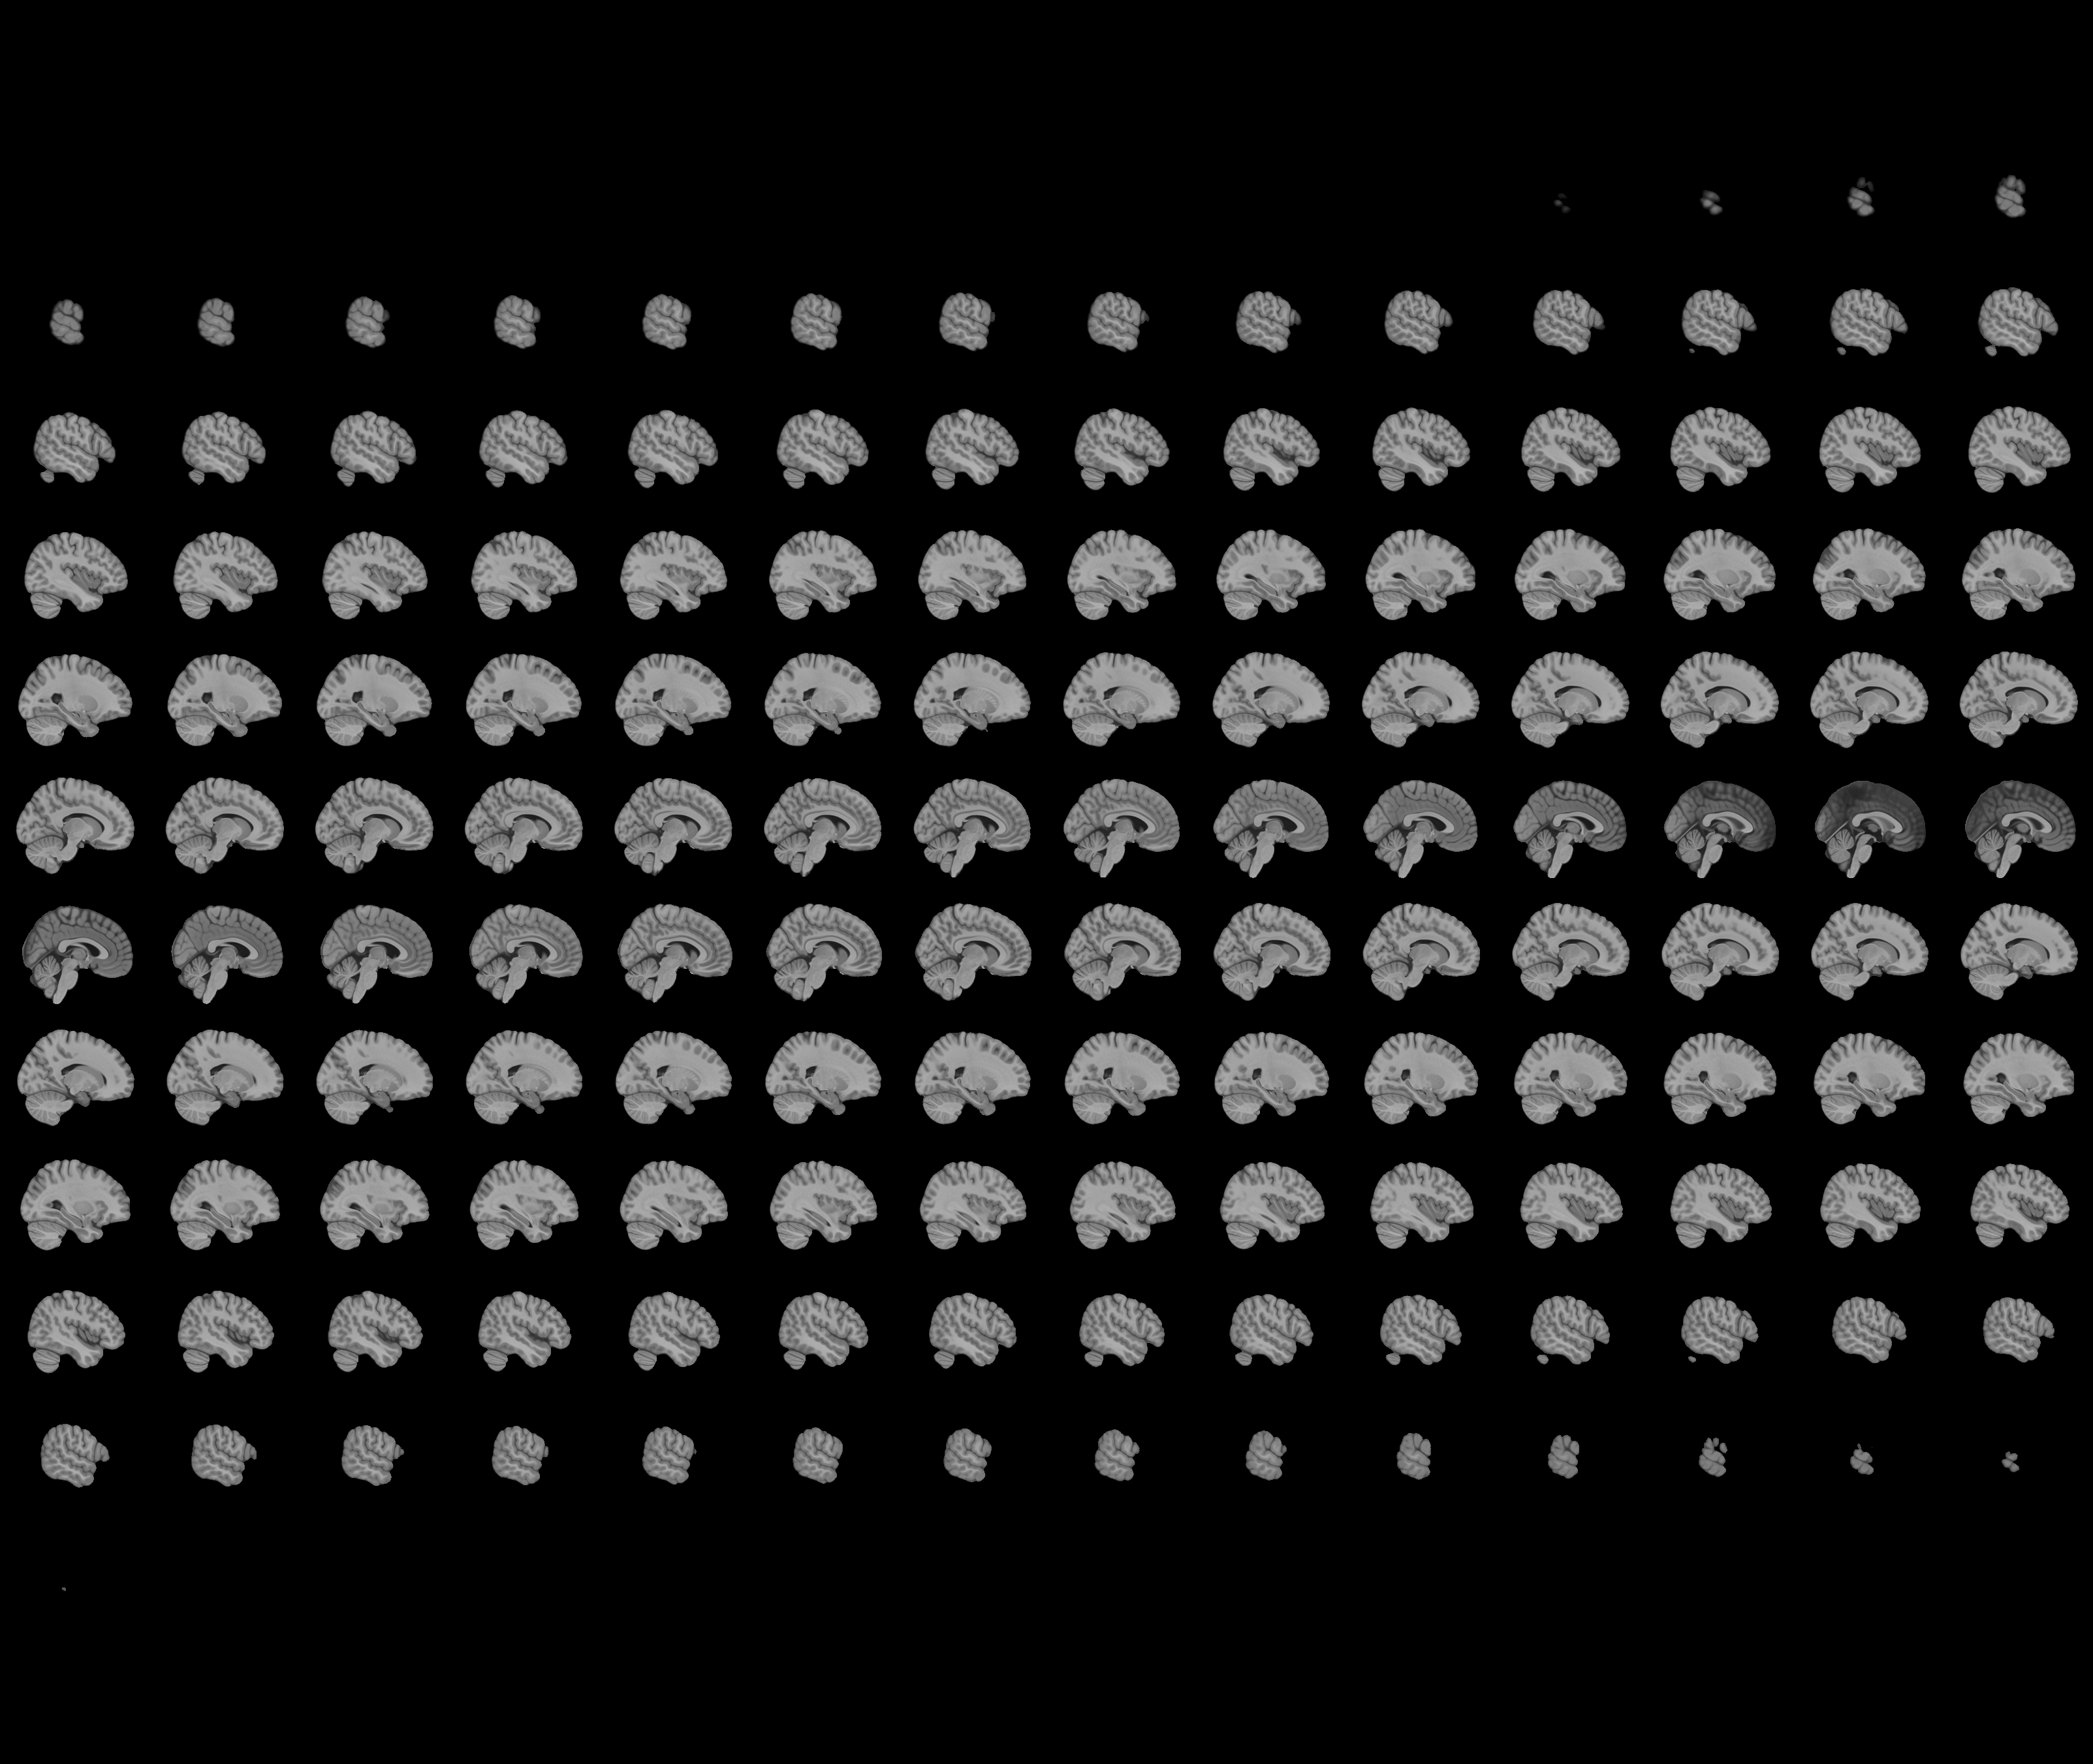
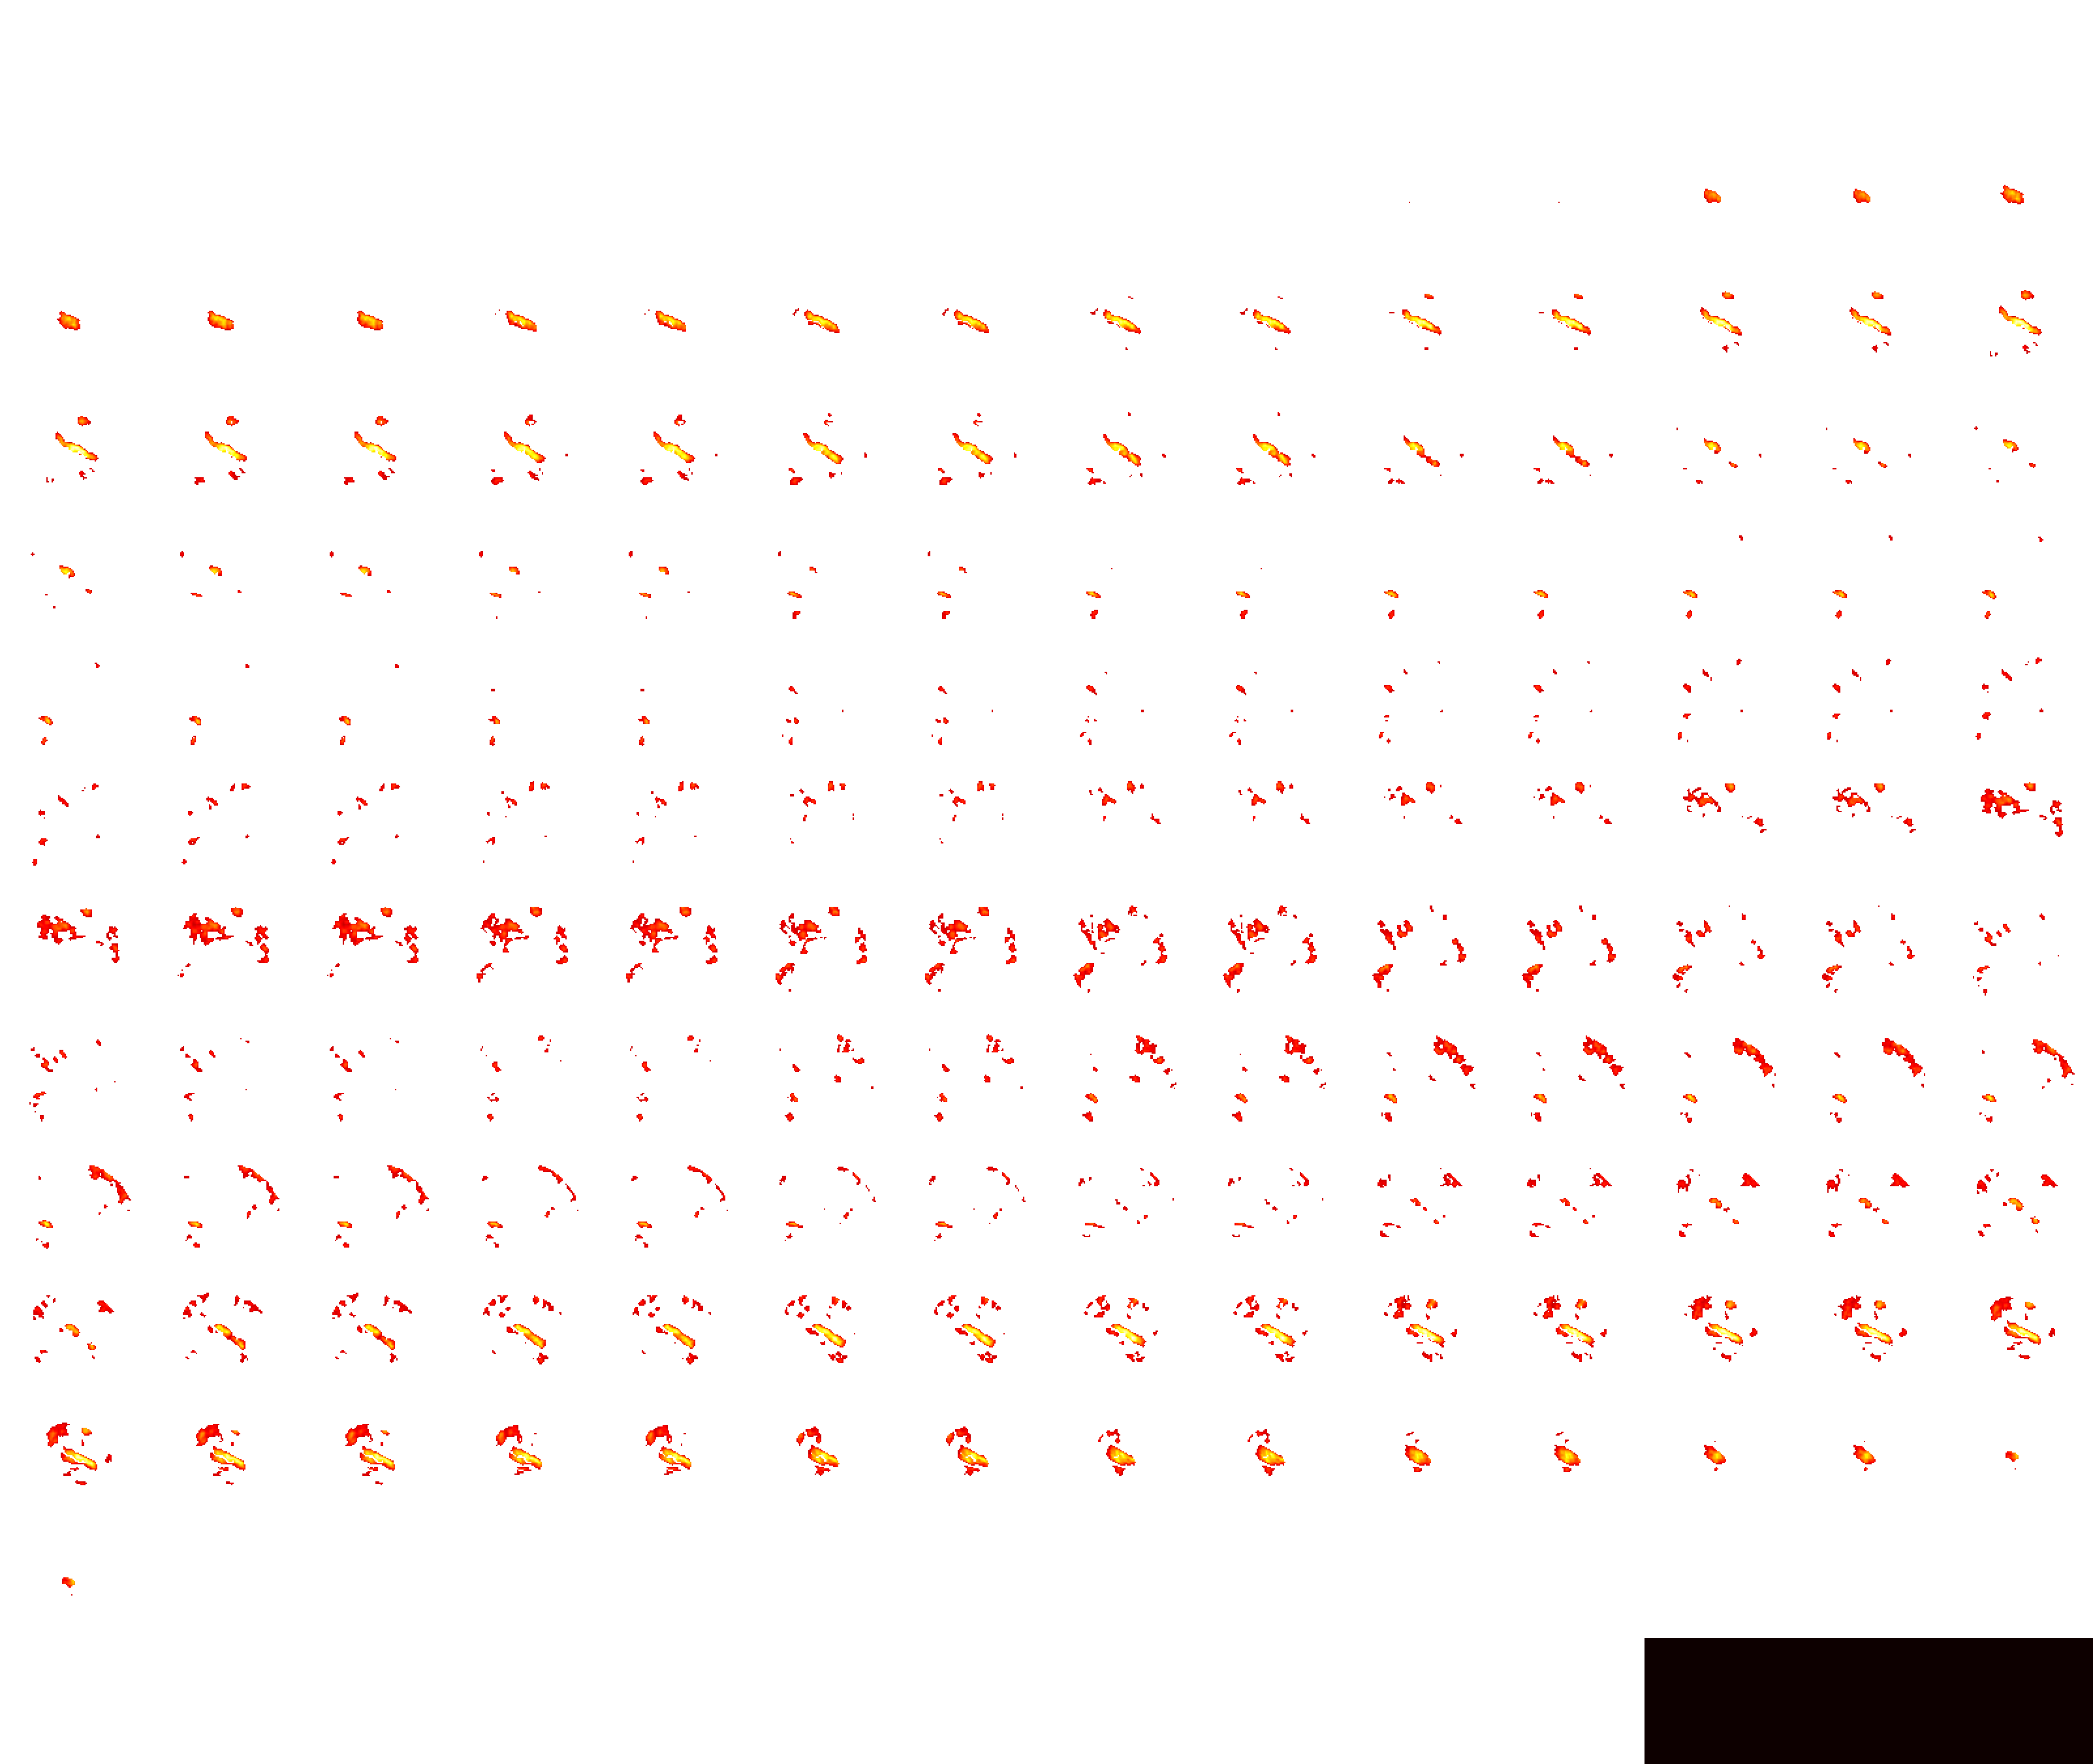

In [25]:
# | label: anova_2ndlevel_view_img
from nilearn.plotting import view_img

view_img(thresholded_map, threshold=threshold, title="F-test: Any Emotion Effect", colorbar=True, bg_img=t1w_img, resampling_interpolation="nearest")

In [26]:
# | label: anova_2ndlevel_cluster_table
from mni_to_atlas import AtlasBrowser
from nilearn.reporting import get_clusters_table

atlas = AtlasBrowser("AAL3")

pd.set_option("display.max_rows", 120)

# Cluster table
table_sum, cluster_map_sum = get_clusters_table(thresholded_map, 0, 1, return_label_maps=True)

# AAL3 labelling
coordinates = table_sum[["X", "Y", "Z"]].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)

# Add the labels to the table
table_sum["AAL3"] = aal_labels

table_sum

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,53.5,1.5,-4.5,18.449056,22224,Temporal_Sup_R
1,1a,53.5,-10.5,3.5,18.021674,,Heschl_R
2,1b,59.5,1.5,-0.5,16.451455,,Temporal_Pole_Sup_R
3,1c,63.5,-16.5,9.5,15.887092,,Temporal_Sup_R
4,2,-52.5,-14.5,5.5,17.823405,22352,Temporal_Sup_L
5,2a,-56.5,-4.5,-0.5,17.740359,,Temporal_Sup_L
6,2b,-54.5,-20.5,7.5,17.493439,,Temporal_Sup_L
7,2c,-46.5,-26.5,11.5,15.179522,,Temporal_Sup_L
8,3,29.5,-60.5,-24.5,14.406896,8104,Cerebellum_6_R
9,3a,11.5,-68.5,-14.5,11.100923,,Cerebellum_6_R


In [27]:
# retrieve the table for the main clusters only (the one for which "Cluster ID" is a number)
table_sum_main = table_sum[table_sum["Cluster ID"].apply(lambda x: isinstance(x, int))]
table_sum_main

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,53.5,1.5,-4.5,18.449056,22224,Temporal_Sup_R
4,2,-52.5,-14.5,5.5,17.823405,22352,Temporal_Sup_L
8,3,29.5,-60.5,-24.5,14.406896,8104,Cerebellum_6_R
12,4,-32.5,-62.5,-22.5,13.272959,2728,Cerebellum_6_L
14,5,55.5,-2.5,45.5,12.047704,2160,Precentral_R
15,6,-0.5,1.5,67.5,11.492586,3752,Supp_Motor_Area_L
18,7,-54.5,-6.5,47.5,11.368053,1864,Postcentral_L
19,8,59.5,-52.5,39.5,10.705533,10408,Parietal_Inf_R
23,9,3.5,-32.5,47.5,10.694677,22528,Cingulate_Mid_R
27,10,27.5,33.5,49.5,10.371796,15008,Frontal_Sup_2_R


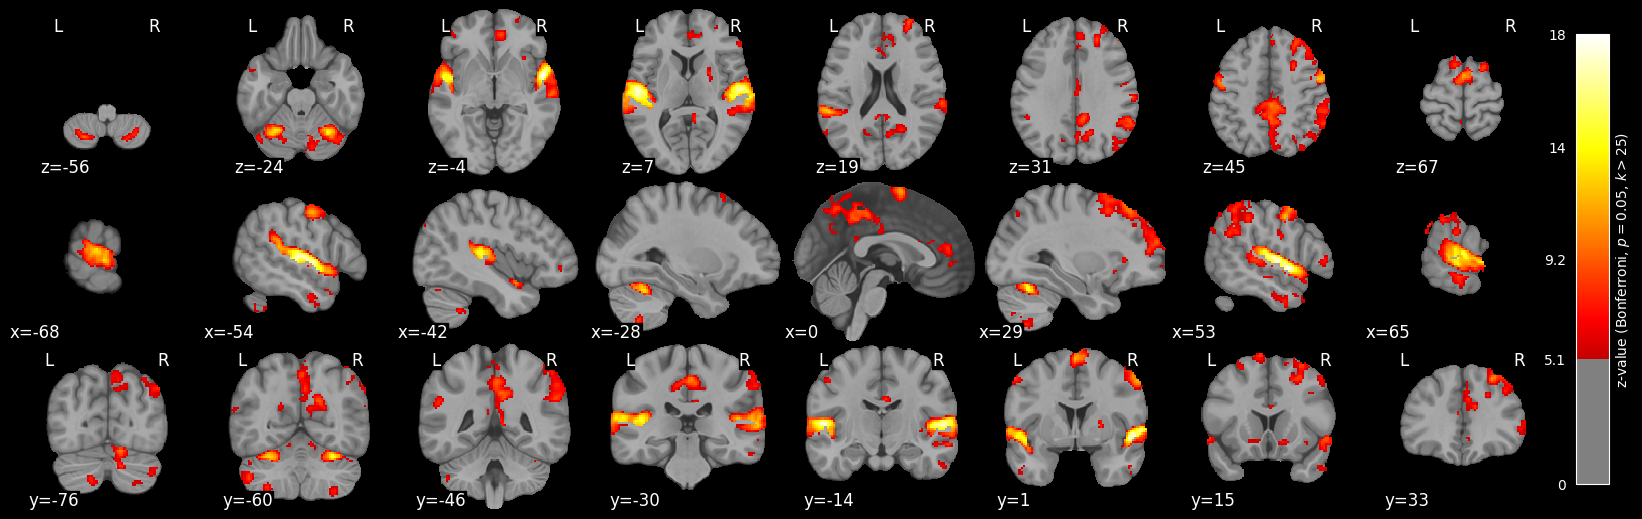

In [29]:
# | label: anova_2ndlevel_mosaic
# beautiful mosaic figure

import matplotlib.pyplot as plt

# Create a new figure and axis with black background
fig = plt.figure(figsize=(16, 5), facecolor="black")

display = plot_stat_map(
    thresholded_map,
    threshold=threshold,
    display_mode="mosaic",
    cut_coords=8,
    colorbar=True,
    symmetric_cbar=False,
    cmap="hot",
    figure=fig,
    bg_img=t1w_img,
    resampling_interpolation="nearest",
)

# Customize the colorbar
cbar = display._cbar
cbar.set_label("z-value (Bonferroni, $p=0.05$, $k>25$)")
# change colorbar label color to white
cbar.ax.yaxis.label.set_color("white")

# Show the plot
plt.show()